# Model Activation Sparsity Analyzer

ReLU's started becoming popular with the AlexNet model back in 2012 and added two main advantages: it gave a significant speed improvement while training over tanh or sigmoid and second it gave a non-linear / partial solution to the vanishing gradient problem. All of this comes from the fact that the identity function is applied to any positive values thus making them unbounded while all negative values are set to 0 adding a non-linear component and thus making ReLU an inexpensive operation. Since then, ReLU's have appeared in most major models across the deep learning field. These models therefore have a lot of naturally occuring zeros in their computation graph. For example, the output from each ReLU in a randomly initialized network is about 50% zeros or in more common terms 50% sparse.

For a trained network, it is empirically found that ReLU's can introduce upwards of 80% sparsity for some of the layers in most models and on average more than 50% for most modern architectures (this can vary upwards by quite a bit based on the architecture). The intuitive reasons for this are a few: ReLUs give the training process a way to remove uncorrelated information or noise from the decision paths, with that removal it is able to create high-dimensional sparse representation spaces that are more easily separated by decision boundaries, and neural networks are overall very redundant in their connections. Another empirical finding is that the first layers are much less sparse than the final layers. The general intuition is that early layers contain general filters that are applicable to most input/output mappings where as the later layers are much more specialized to a specific output or class.

This notebook will walk you through a quick way to visualize the natural sparsity induced from ReLU activations within a selected network for a given dataset. One note is that random data cannot be used to properly view the activations. The degree to which an output from a convolutional layer is positive or negative has a strong prior of the input distribution. With random data, in general, we'll see higher activation sparsity at the beginning of the network as filters fail to find features / correlate with each other and lower activation sparsity at the end of the network as noise compounds / propagates. This shouldn't deter you, though, the activation sparsity is very stable for the full range of train and test input distributions.


In [55]:
import sys
import os

print('Python %s on %s' % (sys.version, sys.platform))

package_path = os.path.abspath(os.path.join(os.path.expanduser(os.getcwd()), os.pardir))
print(package_path)

"""
Adding the path to the neuralmagic-pytorch extension to the path so it isn't necessary to have it installed
"""
sys.path.extend([package_path])


Python 3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] on darwin
/Users/markkurtz/code/neuralmagic/Shared/neuralmagicml-pytorch


### Model Selection

Below you'll find the code for setting up a model for analyzing activation sparsity. Change out the model for your desired model. Note, it should work with any model coded in pytorch.

Additionally run the code block and select the device to run on before continuing.

In [56]:
from neuralmagicML.models import resnet50
import ipywidgets as widgets


"""
change the desired model to run here
"""
model = resnet50()

print('Created model {}'.format(model.__class__.__name__))
model = model.eval()

print('\nChoose the device to run on')
device_choice = widgets.ToggleButtons(options=['cpu', 'cuda'], description='Device')
display(device_choice)

Created model ResNet

Choose the device to run on


ToggleButtons(description='Device', options=('cpu', 'cuda'), value='cpu')

### Analyzer Selection

The below code block will now go through your selected model and offer up a UI for choosing which layers to track. It will execute the model in inference mode once to provide information on how many FLOPS and params for each layer. It may take a few seconds to generate.

Input sparsity will track the sparsity within the input tensor for the given layer. Likewise, output sparsity will track the sparsity within the output tensor for the given layer. Input distribution will sample the input tensor (1000 samples per element from the dataset) for histogram visualization later. Likewise, output distribution will sample the output tensor (1000 samples per element from the dataset) for histogram visualization later.

In [57]:
from neuralmagicML.notebooks import ASAnalyzerWidgets

device = device_choice.value

print('running on device {}'.format(device))
print('creating activation sparsity analyzer widgets (need to execute the model, so may take some time)...')
wid, analyzer_layers = ASAnalyzerWidgets.interactive_module(model, device, inp_dim=(1, 3, 224, 224))
display(wid)


running on device cpu
creating activation sparsity analyzer widgets (need to execute the model, so may take some time)...


Accordion(children=(Box(children=(VBox(children=(VBox(children=(Checkbox(value=False, description='toggle all …

### Dataset Selection

Below the code for setting up a dataset is given and defaulted to the ImageNet dataset. This must be changed to whatever dataset the model you selected above was trained on. It supports any general supervised dataset.

Additionally after selecting the dataset and hitting run, use the sliders to select the number of samples and batch size. The number of samples are the number of individual elements from the dataset that will be run through the model in inference mode for calculating activation sparsity. The batch size is the number of individual elements that will be run through the model at once.


In [60]:
from neuralmagicML.datasets import ImageNetDataset, EarlyStopDataSet
from neuralmagicML.sparsity import ASAnalyzerModule

"""
change the desired dataset to run on and the path to it here

Note, for the default ImageNetDataset you may run into issues with download if already downloaded (pytorch bug)
If this is case, set download=True and run. This will download the meta file but will not progress any further
After that set download=False and it will work
"""
dataset_root = os.path.abspath(os.path.expanduser('~/datasets/ILSVRC2012'))
dataset = ImageNetDataset(dataset_root, train=False, download=False)

print(dataset)

print('\nChoose the number of samples and batch size to run through the model for calculating AS')
print('(press enter if/after inputting manually)')
sample_size_slider = widgets.IntSlider(value=1, min=1, max=len(dataset), step=1, description='Samples:')
batch_size_slider = widgets.IntSlider(value=1, min=1, max=256, step=1, description='Batch Size:')
display(sample_size_slider)
display(batch_size_slider)


Dataset ImageNetDataset
    Number of datapoints: 50000
    Root location: /Users/markkurtz/datasets/ILSVRC2012
    Split: val

Choose the number of samples and batch size to run through the model for calculating AS
(press enter if/after inputting manually)


IntSlider(value=1, description='Samples:', max=50000, min=1)

IntSlider(value=1, description='Batch Size:', max=256, min=1)

### Test Section

Below we'll setup the proper variables for use and then run the desired amount of samples from the given dataset through the given model for inference. The given settings for tracking activation statistics will apply. 

This may take some time depending on your settings, so wait until 'Complete' appears before continuing. A progress bar is given to keep track.

In [63]:
import torch
from torch.utils.data import DataLoader
import progressbar


analyzer_module = ASAnalyzerModule(model, analyzer_layers)
print('created analyzer module for {} with {} analyzed layers\n'
      .format(model.__class__.__name__, len([lay for lay in analyzer_layers if lay.enabled])))

sample_size = sample_size_slider.value
batch_size = batch_size_slider.value

print('running model for {} samples from the dataset at batch size {}'
      .format(sample_size, batch_size))

data_loader = DataLoader(EarlyStopDataSet(dataset, sample_size), batch_size=batch_size, num_workers=4)
bar = progressbar.ProgressBar(
    widgets=['Running samples: ', progressbar.SimpleProgress(),
             ' [', progressbar.Percentage(), ']\t', 
             '\t(', progressbar.Timer(), '\t', progressbar.ETA(), ') '],
    maxval=sample_size)

with torch.no_grad():
    for batch, (*x_feature, y_lab) in enumerate(data_loader):
        y_lab = y_lab.to(device)
        x_feature = tuple([dat.to(device) for dat in x_feature])
        y_pred = model(*x_feature)
        bar.update(batch * batch_size if batch * batch_size < sample_size else sample_size - 1)
        
bar.finish()
print('Completed')
    

created analyzer module for ResNet with 54 analyzed layers

running model for 10 samples from the dataset at batch size 1


Running samples: 10 of 10 [100%]		(Elapsed Time: 0:00:03	Time:  0:00:03)       


Completed


### Visualization Section

Below we visualize the results through multiple possible plots. Each plot will only be shown if there is at least one layer that requested it. If you would like to save any of the data for other use simply print out a json string of the 'data' var after it has been populated. It contains information of the mean and standard of deviation of the sparsity.


Creating inputs sparsity chart...


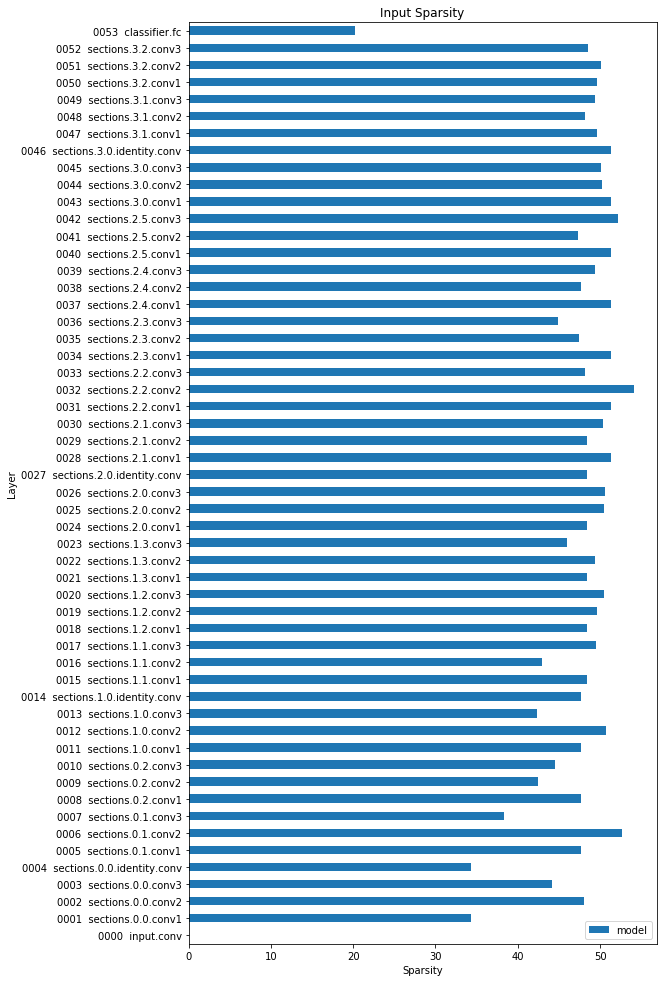

In [64]:
import matplotlib.pyplot as plt
import pandas


# plot input sparsities
input_sparsity_analyzers = [analyz for analyz in analyzer_layers if analyz.track_inputs_sparsity]

if len(input_sparsity_analyzers) > 0:
    print('Creating inputs sparsity chart...')
    data = {}
    
    for index, analyz in enumerate(input_sparsity_analyzers):
        data[analyz.name] = {'mean': analyz.inputs_sparsity_mean.item(),
                             'stddev': analyz.inputs_sparsity_std.item(),
                             'ordered_key': '{:04d}  {}'.format(index, analyz.name)}
    
    height = round(len(plt_data) / 4) + 3
    fig = plt.figure(figsize=(10, height))
    ax = fig.add_subplot(111)
    ax.set_title('Input Sparsity')
    ax.set_xlabel('Sparsity')
    ax.set_ylabel('Layer')
    plt.subplots_adjust(left=0.3, bottom=0.1, right=0.95, top=0.9)
    frame = pandas.DataFrame(data={'model': {val['ordered_key']: val['mean'] * 100.0
                                             for val in data.values()}})
    frame.plot.barh(ax=ax)
    plt.show()

# plot output sparsities
output_sparsity_analyzers = [analyz for analyz in analyzer_layers if analyz.track_outputs_sparsity]

if len(output_sparsity_analyzers) > 0:
    print('Creating outputs sparsity chart...')
    data = {}
    
    for index, analyz in enumerate(output_sparsity_analyzers):
        data[analyz.name] = {'mean': analyz.outputs_sparsity_mean.item(),
                             'stddev': analyz.outputs_sparsity_std.item(),
                             'ordered_key': '{:04d}  {}'.format(index, analyz.name)}
    
    height = round(len(plt_data) / 4) + 3
    fig = plt.figure(figsize=(10, height))
    ax = fig.add_subplot(111)
    ax.set_title('Output Sparsity')
    ax.set_xlabel('Sparsity')
    ax.set_ylabel('Layer')
    plt.subplots_adjust(left=0.3, bottom=0.1, right=0.95, top=0.9)
    frame = pandas.DataFrame(data={'model': {val['ordered_key']: val['mean'] * 100.0
                                             for val in data.values()}})
    frame.plot.barh(ax=ax)
    plt.show()

# plot input distributions
input_distribution_analyzers = [analyz for analyz in analyzer_layers if analyz.inputs_sample_size > 0]

if len(input_distribution_analyzers) > 0:
    print('Creating input distribution charts...')
    
    for analyz in input_distribution_analyzers:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        title = '{} Input Distribution'.format(analyz.name)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        frame = pandas.DataFrame(data={title: torch.cat(analyz.inputs_sample).view(-1).tolist()})
        frame.hist(column=title, bins=256, ax=ax)
        plt.show()

# plot output distributions
output_distribution_analyzers = [analyz for analyz in analyzer_layers if analyz.outputs_sample_size > 0]

if len(output_distribution_analyzers) > 0:
    print('Creating output distribution charts...')
    
    for analyz in output_distribution_analyzers:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        title = '{} Output Distribution'.format(analyz.name)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        frame = pandas.DataFrame(data={title: torch.cat(analyz.outputs_sample).view(-1).tolist()})
        frame.hist(column=title, bins=256, ax=ax)
        plt.show()
